# 1. Create strain-specific model 

Create and save strain-specific models with the homology matrix and curated base model

In [1]:
#import package
from cobra import Model, Reaction, Metabolite
import cobra
import pandas as pd 
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)
import os

import warnings
warnings.simplefilter("ignore", UserWarning)


In [2]:
#A function to create strain-specific model from homology matrix 
#Input of Function: 
# data: specify the homology file. e.g. data =pd.read_csv('./data/homology.csv')
# input_model: your curated base model. e.g. input_model=cobra.io.load_json_model('./data/ecoli_core.json')
# output_path: final destination where you want to save the models e.g. output_path='./data/strain_specific_models'

def build_draft_strain_specific_models(data,input_model,output_path):
    
    for o in data.columns:
        missing_genes = data[pd.isnull(data[o])][o].index.tolist()
        print len(missing_genes)

        # INSERT YOUR MODEL HERE
        model =cobra.io.load_json_model( input_model)
 
        model.name = o
        model.id = o
        knockout_genes = []
        
        for gene in missing_genes:
            knockout_genes.append(model.genes.get_by_id(gene))
            
        if len(missing_genes) > 0:  
            
            #Knock out reaction
            knockoutReactions = cobra.manipulation.delete.find_gene_knockout_reactions(model, knockout_genes)
            for reaction in knockoutReactions:
                model.reactions.get_by_id(reaction.id).delete()
                
            #Knock out genes    
            for gene in missing_genes:
                model.genes.remove(gene)
                
            model.optimize()
            print model, model.optimize().f, len(model._trimmed_genes), len(model._trimmed_reactions)
        
        else:
            model.optimize()
            print model, model.optimize().f, 0, 0
            
        print len(model.reactions)
     
        #o = o.replace("/","-")
        cobra.io.save_json_model(model, output_path+model.name+'.json')

In [12]:
print len(input_model.genes)
for gene in input_model.genes: 
    print gene.id
    count=0
    for rxn in input_model.reactions: 
        if gene.id in rxn.gene_reaction_rule: 
            count=count+1
    #print count
    if count==0: 
        input_model.genes.remove(gene)
print len(input_model.genes)
#input_model.genes

NameError: name 'input_model' is not defined

In [30]:
#define input first 

input_model = '../S_oralis/model_curation/SO/SO_model_fixed1.json'
model=cobra.io.load_json_model('../S_oralis/model_curation/SO/SO_model_fixed1.json')

                               
#input_model = 'C:\Users\isabel\Downloads/SO_model_fixed1.json'
#model=cobra.io.load_json_model('C:\Users\isabel\Downloads/SO_model_fixed1.json')


In [31]:
growthThreshold=0.01*(model.optimize().f)
print growthThreshold

0.000165184224631


In [4]:
#filter for gene present in both homology matrix and model
#data =pd.read_csv('C:\Users\isabel\Downloads/Orthogonality_matrix_S_oralis_new.csv',index_col=0)
data =pd.read_csv('../S_oralis/Orthogonality_matrix_S_oralis_new.csv',index_col=0)
modelgene=[gene.id for gene in model.genes]
genelist=list(data.index)
genelist_str=[str(gene) for gene in genelist]
data.index=genelist_str
final_genelist=[gene for gene in modelgene if gene in genelist_str]
print len(final_genelist)
data=data.loc[final_genelist]
#build_draft_strain_specific_models(data,input_model,'C:\Users\isabel\Downloads\strains/')
build_draft_strain_specific_models(data,input_model,'../S_oralis/strains/')

398
42
1077464_22 -1.27623727201e-31 0 0
667
29
1077464.27 0.0 0 0
676
29
1891914.10 0.0165184224631 0 0
674
30
1077464.28 3.21668129115e-49 0 0
673
39
1077464.25 0.0 0 0
665
56
1303.81 1.92406338087e-17 0 0
627
59
1303.87 0.0 0 0
639
28
1891914.14 0.0 0 0
673
35
1333864.3 0.0 0 0
668
31
1303.74 0.0 0 0
671
29
1303.83 0.0 0 0
672
32
1458253.7 0.0 0 0
655
30
927666.3 0.0 0 0
673
26
1095739.3 0.0165184224631 0 0
676
174
1303.75 0.0 0 0
501
23
1891914.7 0.0165184224631 0 0
680
25
1303.71 -2.6793888093e-16 0 0
675
39
1297534.3 0.0 0 0
657
29
1303.86 0.0165184224631 0 0
677
0
1303.43 0.0165184224631 0 0
686
25
655813.4 0.0165184224631 0 0
672
31
1303.134 0.0165184224631 0 0
671
35
1282665.3 -1.66377572227e-45 0 0
668
33
1303.80 0.0 0 0
658
30
1891914.6 0.0165184224631 0 0
674
37
1458253.8 0.0 0 0
644
27
1095741.3 0.0165184224631 0 0
675
22
1303.70 0.0 0 0
678
33
1303.78 0.0 0 0
671
41
1297857.3 0.0 0 0
642
30
1077464.32 0.0 0 0
677
27
1891914.9 -1.33285651221e-17 0 0
674
48
1303.84 0.0 0 0


# 2. Create figure for pan/core reactions

1. Loop through all the reactions in all the models, count the number occurence of reactions in all the models
2. If a reaction is present in all models, it's considered a core reaction. Otherwise it's a pan reaction 
3. Plot the figure that shows the distribution of pan/core reaction in different subsystems

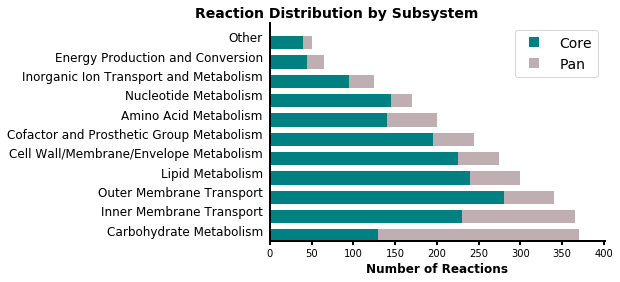

In [87]:
# create the figure for pan/core reaction distribution for different subsystems (ONLY FOR PLOTTING)

''' 
Code used to generate Figure 1, modeled after Monk et al. PNAS 110(50) 2013
Fig. 1: Examine the 'core' and 'pan' metabolic capabilities of the multistrain organism

2015 jtyurkovich
'''

from matplotlib.legend_handler import HandlerPatch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# to get squares in legend
class HandlerSquare(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = xdescent + 0.5 * (width - height), ydescent
        p = mpatches.Rectangle(xy=center, width=height,
                               height=height, angle=0.0)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]  

# define major subsystems (y axis labels)
# TODO: replace with new results
subsystems = (
    'Carbohydrate Metabolism',
    'Inner Membrane Transport',
    'Outer Membrane Transport',
    'Lipid Metabolism',
    'Cell Wall/Membrane/Envelope Metabolism',
    'Cofactor and Prosthetic Group Metabolism',
    'Amino Acid Metabolism',
    'Nucleotide Metabolism',
    'Inorganic Ion Transport and Metabolism',
    'Energy Production and Conversion',
    'Other'
)

# define number of core reactions
# TODO: replace with new results
core = (
    130,
    230,
    280,
    240,
    225,
    195,
    140,
    145,
    95,
    45,
    40
)

# define number of pan reactions
# TODO: replace with new results
pan = (
    240,
    135,
    60,
    60,
    50,
    50,
    60,
    25,
    30,
    20,
    10
)

# plot horizontal stacked bar chart
fig = plt.figure()
ax = fig.add_subplot(111)

n = range(len(subsystems))
p1 = plt.barh(n, core, 0.7, color='#008080')
p2 = plt.barh(n, pan, 0.7, color='#bfafb2', left=core)

n = [x + 0.325 for x in n]
plt.yticks(n, subsystems, size=12)
plt.legend((p1[0], p2[0]), ('Core', 'Pan'), fontsize=14, handler_map={p1[0]: HandlerSquare(), p2[0]: HandlerSquare()})
plt.xlim(0, 401)
plt.ylim(-0.25, len(subsystems))
plt.xlabel('Number of Reactions', fontweight='bold', size=12)
plt.title('Reaction Distribution by Subsystem', fontweight='bold', size=14, x=0.2)

plt.tick_params(
    axis='y',
    which='both',
    left='off',
    right='off',
    width=2
)

plt.tick_params(
    axis='x',
    which='both',
    direction='out',
    top='off',
    width=2
)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['left', 'bottom']:
    ax.spines[axis].set_linewidth(2)
    
plt.show()
fig.savefig('fig-1.png', bbox_inches='tight', dpi=300)
fig.savefig('fig-1.pdf', bbox_inches='tight', dpi=300)

# 3.  Sythesis of biomass components

For all the models: 
    loop through all the metabolites in the biomass reactions, add a demand reaction for the metabolite and set is as the objective function of the model. Record the ability to produce the metabolites in a dataframe. 
    
Plot the heatmap: one axis is metabolites in biomass reaction, one axis should be strains (script for plotting is attached below)

In [6]:
#e_coli = cobra.io.load_json_model('../Resources/data/e_coli_core.json')
e_coli = cobra.io.load_json_model('C:\Users\isabel\Downloads/e_coli_core.json')

new_biomass = e_coli.reactions.BIOMASS_Ecoli_core_w_GAM

#directory = '../S_oralis/strains/'
directory = 'C:\Users\isabel\Downloads\strains/'

model=cobra.io.load_json_model('C:\Users\isabel\Downloads/SO_model_fixed1.json')
#model=cobra.io.load_json_model('../S_oralis/model_curation/SO/SO_model_fixed1.json')
model.add_reaction(new_biomass)
model.reactions.BIOMASS_Ecoli_core_w_GAM.objective_coefficient=0

#threshold=0.01 

dic_part3={}


#for metabolite in new_biomass.metabolites:#input_model.reactions.biomass.metabolites:
    
    #for filename in os.listdir(directory):
count = 0
for filename in os.listdir(directory):
    
    strain = cobra.io.load_json_model(directory + filename)
    strain.add_reaction(new_biomass)
    model.add_reaction(new_biomass)
    strain.reactions.BIOMASS_Ecoli_core_w_GAM.objective_coefficient=1
    model.reactions.BIOMASS_Ecoli_core_w_GAM.objective_coefficient=1
    growthThreshold = 0.01*(model.optimize().f)
    print(growthThreshold)
    print(strain.optimize().f)
    model.reactions.BIOMASS_Ecoli_core_w_GAM.objective_coefficient=0
    #if strain.optimize().f > growthThreshold:
    strain.reactions.BIOMASS_Ecoli_core_w_GAM.objective_coefficient=0
    
    
    metabolites_list=[]
    aux=[]
    
    for metabolite in new_biomass.metabolites:#input_model.reactions.biomass.metabolites:
            
        R_metabolites = Reaction('R_metabolites')
        R_metabolites.subsystem = 'New'
        R_metabolites.lower_bound = -0.
        R_metabolites.upper_bound = 1000.
        R_metabolites.add_metabolites({
            metabolite : -1.0,
            })
        print R_metabolites.reaction
        strain.add_reactions([R_metabolites])
        model.add_reactions([R_metabolites])
        strain.reactions.R_metabolites.objective_coefficient=1
        model.reactions.R_metabolites.objective_coefficient=1
        #strain.optimize()
        threshold=0.01*model.optimize().f
            
            
                               
            #print strain.name, strain.optimize().f, metabolite
            #print model.name, model.optimize().f, metabolite
            #difference=abs(abs(strain.optimize().f)-abs(model.optimize().f))
            #print difference
        
            #if difference < threshold and strain.optimize().f > 0:
        if strain.optimize().f > threshold and strain.optimize().f > 0:
            aux.append(1)
        else:
            aux.append(0)
            
                       
        metabolites_list.append(str(metabolite))
        dic_part3.update({str(strain.name):aux})
        strain.reactions.R_metabolites.objective_coefficient=0
        model.reactions.R_metabolites.objective_coefficient=0
            
        print strain.reactions.R_metabolites
        print model.reactions.R_metabolites
            
        strain = cobra.io.load_json_model(directory + filename)
        strain.add_reaction(new_biomass)
        model=cobra.io.load_json_model('C:\Users\isabel\Downloads/SO_model_fixed1.json')
        model.add_reaction(new_biomass)
        model.reactions.BIOMASS_Ecoli_core_w_GAM.objective_coefficient=0
        strain.reactions.BIOMASS_Ecoli_core_w_GAM.objective_coefficient=0
    
          
            
    print(aux)
           
           


0.000705242053104
-2.41311113306e-14
f6p_c --> 
R_metabolites: f6p_c --> 
R_metabolites: f6p_c --> 
glu__L_c --> 
R_metabolites: glu__L_c --> 
R_metabolites: glu__L_c --> 
nad_c --> 
R_metabolites: nad_c --> 
R_metabolites: nad_c --> 
coa_c --> 
R_metabolites: coa_c --> 
R_metabolites: coa_c --> 
g3p_c --> 
R_metabolites: g3p_c --> 
R_metabolites: g3p_c --> 
g6p_c --> 
R_metabolites: g6p_c --> 
R_metabolites: g6p_c --> 
atp_c --> 
R_metabolites: atp_c --> 
R_metabolites: atp_c --> 
3pg_c --> 
R_metabolites: 3pg_c --> 
R_metabolites: 3pg_c --> 
nadh_c --> 
R_metabolites: nadh_c --> 
R_metabolites: nadh_c --> 
e4p_c --> 
R_metabolites: e4p_c --> 
R_metabolites: e4p_c --> 
gln__L_c --> 
R_metabolites: gln__L_c --> 
R_metabolites: gln__L_c --> 
r5p_c --> 
R_metabolites: r5p_c --> 
R_metabolites: r5p_c --> 
akg_c --> 
R_metabolites: akg_c --> 
R_metabolites: akg_c --> 
nadph_c --> 
R_metabolites: nadph_c --> 
R_metabolites: nadph_c --> 
pi_c --> 
R_metabolites: pi_c --> 
R_metabolites: pi_c

g3p_c --> 
R_metabolites: g3p_c --> 
R_metabolites: g3p_c --> 
nadph_c --> 
R_metabolites: nadph_c --> 
R_metabolites: nadph_c --> 
h_c --> 
R_metabolites: h_c --> 
R_metabolites: h_c --> 
nadp_c --> 
R_metabolites: nadp_c --> 
R_metabolites: nadp_c --> 
gln__L_c --> 
R_metabolites: gln__L_c --> 
R_metabolites: gln__L_c --> 
pi_c --> 
R_metabolites: pi_c --> 
R_metabolites: pi_c --> 
r5p_c --> 
R_metabolites: r5p_c --> 
R_metabolites: r5p_c --> 
atp_c --> 
R_metabolites: atp_c --> 
R_metabolites: atp_c --> 
nadh_c --> 
R_metabolites: nadh_c --> 
R_metabolites: nadh_c --> 
accoa_c --> 
R_metabolites: accoa_c --> 
R_metabolites: accoa_c --> 
nad_c --> 
R_metabolites: nad_c --> 
R_metabolites: nad_c --> 
pyr_c --> 
R_metabolites: pyr_c --> 
R_metabolites: pyr_c --> 
glu__L_c --> 
R_metabolites: glu__L_c --> 
R_metabolites: glu__L_c --> 
pep_c --> 
R_metabolites: pep_c --> 
R_metabolites: pep_c --> 
3pg_c --> 
R_metabolites: 3pg_c --> 
R_metabolites: 3pg_c --> 
h2o_c --> 
R_metabolites: h2

g6p_c --> 
R_metabolites: g6p_c --> 
R_metabolites: g6p_c --> 
h_c --> 
R_metabolites: h_c --> 
R_metabolites: h_c --> 
g3p_c --> 
R_metabolites: g3p_c --> 
R_metabolites: g3p_c --> 
nad_c --> 
R_metabolites: nad_c --> 
R_metabolites: nad_c --> 
nadh_c --> 
R_metabolites: nadh_c --> 
R_metabolites: nadh_c --> 
f6p_c --> 
R_metabolites: f6p_c --> 
R_metabolites: f6p_c --> 
nadp_c --> 
R_metabolites: nadp_c --> 
R_metabolites: nadp_c --> 
akg_c --> 
R_metabolites: akg_c --> 
R_metabolites: akg_c --> 
nadph_c --> 
R_metabolites: nadph_c --> 
R_metabolites: nadph_c --> 
pi_c --> 
R_metabolites: pi_c --> 
R_metabolites: pi_c --> 
glu__L_c --> 
R_metabolites: glu__L_c --> 
R_metabolites: glu__L_c --> 
atp_c --> 
R_metabolites: atp_c --> 
R_metabolites: atp_c --> 
gln__L_c --> 
R_metabolites: gln__L_c --> 
R_metabolites: gln__L_c --> 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.000705242053104
0.110814123611
oaa_c --> 
R_metabolites: oaa_c --> 
R_metabolites: oaa_c

akg_c --> 
R_metabolites: akg_c --> 
R_metabolites: akg_c --> 
atp_c --> 
R_metabolites: atp_c --> 
R_metabolites: atp_c --> 
f6p_c --> 
R_metabolites: f6p_c --> 
R_metabolites: f6p_c --> 
pep_c --> 
R_metabolites: pep_c --> 
R_metabolites: pep_c --> 
3pg_c --> 
R_metabolites: 3pg_c --> 
R_metabolites: 3pg_c --> 
e4p_c --> 
R_metabolites: e4p_c --> 
R_metabolites: e4p_c --> 
g6p_c --> 
R_metabolites: g6p_c --> 
R_metabolites: g6p_c --> 
h2o_c --> 
R_metabolites: h2o_c --> 
R_metabolites: h2o_c --> 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.000705242053104
5.14595226282e-18
f6p_c --> 
R_metabolites: f6p_c --> 
R_metabolites: f6p_c --> 
pep_c --> 
R_metabolites: pep_c --> 
R_metabolites: pep_c --> 
h2o_c --> 
R_metabolites: h2o_c --> 
R_metabolites: h2o_c --> 
oaa_c --> 
R_metabolites: oaa_c --> 
R_metabolites: oaa_c --> 
h_c --> 
R_metabolites: h_c --> 
R_metabolites: h_c --> 
nad_c --> 
R_metabolites: nad_c --> 
R_metabolites: nad_c --> 
g3p_c --> 
R_metab

accoa_c --> 
R_metabolites: accoa_c --> 
R_metabolites: accoa_c --> 
g3p_c --> 
R_metabolites: g3p_c --> 
R_metabolites: g3p_c --> 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.000705242053104
1.70379227005e-12
akg_c --> 
R_metabolites: akg_c --> 
R_metabolites: akg_c --> 
g3p_c --> 
R_metabolites: g3p_c --> 
R_metabolites: g3p_c --> 
h_c --> 
R_metabolites: h_c --> 
R_metabolites: h_c --> 
atp_c --> 
R_metabolites: atp_c --> 
R_metabolites: atp_c --> 
h2o_c --> 
R_metabolites: h2o_c --> 
R_metabolites: h2o_c --> 
glu__L_c --> 
R_metabolites: glu__L_c --> 
R_metabolites: glu__L_c --> 
pep_c --> 
R_metabolites: pep_c --> 
R_metabolites: pep_c --> 
g6p_c --> 
R_metabolites: g6p_c --> 
R_metabolites: g6p_c --> 
nadh_c --> 
R_metabolites: nadh_c --> 
R_metabolites: nadh_c --> 
e4p_c --> 
R_metabolites: e4p_c --> 
R_metabolites: e4p_c --> 
f6p_c --> 
R_metabolites: f6p_c --> 
R_metabolites: f6p_c --> 
3pg_c --> 
R_metabolites: 3pg_c --> 
R_metabolites: 3pg_c --> 


f6p_c --> 
R_metabolites: f6p_c --> 
R_metabolites: f6p_c --> 
adp_c --> 
R_metabolites: adp_c --> 
R_metabolites: adp_c --> 
gln__L_c --> 
R_metabolites: gln__L_c --> 
R_metabolites: gln__L_c --> 
h_c --> 
R_metabolites: h_c --> 
R_metabolites: h_c --> 
nadp_c --> 
R_metabolites: nadp_c --> 
R_metabolites: nadp_c --> 
e4p_c --> 
R_metabolites: e4p_c --> 
R_metabolites: e4p_c --> 
nadph_c --> 
R_metabolites: nadph_c --> 
R_metabolites: nadph_c --> 
g3p_c --> 
R_metabolites: g3p_c --> 
R_metabolites: g3p_c --> 
glu__L_c --> 
R_metabolites: glu__L_c --> 
R_metabolites: glu__L_c --> 
pep_c --> 
R_metabolites: pep_c --> 
R_metabolites: pep_c --> 
accoa_c --> 
R_metabolites: accoa_c --> 
R_metabolites: accoa_c --> 
3pg_c --> 
R_metabolites: 3pg_c --> 
R_metabolites: 3pg_c --> 
h2o_c --> 
R_metabolites: h2o_c --> 
R_metabolites: h2o_c --> 
g6p_c --> 
R_metabolites: g6p_c --> 
R_metabolites: g6p_c --> 
nad_c --> 
R_metabolites: nad_c --> 
R_metabolites: nad_c --> 
pyr_c --> 
R_metabolites: py

g3p_c --> 
R_metabolites: g3p_c --> 
R_metabolites: g3p_c --> 
adp_c --> 
R_metabolites: adp_c --> 
R_metabolites: adp_c --> 
pi_c --> 
R_metabolites: pi_c --> 
R_metabolites: pi_c --> 
3pg_c --> 
R_metabolites: 3pg_c --> 
R_metabolites: 3pg_c --> 
pep_c --> 
R_metabolites: pep_c --> 
R_metabolites: pep_c --> 
atp_c --> 
R_metabolites: atp_c --> 
R_metabolites: atp_c --> 
r5p_c --> 
R_metabolites: r5p_c --> 
R_metabolites: r5p_c --> 
pyr_c --> 
R_metabolites: pyr_c --> 
R_metabolites: pyr_c --> 
e4p_c --> 
R_metabolites: e4p_c --> 
R_metabolites: e4p_c --> 
nadp_c --> 
R_metabolites: nadp_c --> 
R_metabolites: nadp_c --> 
f6p_c --> 
R_metabolites: f6p_c --> 
R_metabolites: f6p_c --> 
h_c --> 
R_metabolites: h_c --> 
R_metabolites: h_c --> 
coa_c --> 
R_metabolites: coa_c --> 
R_metabolites: coa_c --> 
nadh_c --> 
R_metabolites: nadh_c --> 
R_metabolites: nadh_c --> 
oaa_c --> 
R_metabolites: oaa_c --> 
R_metabolites: oaa_c --> 
nadph_c --> 
R_metabolites: nadph_c --> 
R_metabolites: na

e4p_c --> 
R_metabolites: e4p_c --> 
R_metabolites: e4p_c --> 
pyr_c --> 
R_metabolites: pyr_c --> 
R_metabolites: pyr_c --> 
coa_c --> 
R_metabolites: coa_c --> 
R_metabolites: coa_c --> 
pep_c --> 
R_metabolites: pep_c --> 
R_metabolites: pep_c --> 
accoa_c --> 
R_metabolites: accoa_c --> 
R_metabolites: accoa_c --> 
adp_c --> 
R_metabolites: adp_c --> 
R_metabolites: adp_c --> 
h2o_c --> 
R_metabolites: h2o_c --> 
R_metabolites: h2o_c --> 
r5p_c --> 
R_metabolites: r5p_c --> 
R_metabolites: r5p_c --> 
f6p_c --> 
R_metabolites: f6p_c --> 
R_metabolites: f6p_c --> 
oaa_c --> 
R_metabolites: oaa_c --> 
R_metabolites: oaa_c --> 
h_c --> 
R_metabolites: h_c --> 
R_metabolites: h_c --> 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.000705242053104
0.0
f6p_c --> 
R_metabolites: f6p_c --> 
R_metabolites: f6p_c --> 
glu__L_c --> 
R_metabolites: glu__L_c --> 
R_metabolites: glu__L_c --> 
atp_c --> 
R_metabolites: atp_c --> 
R_metabolites: atp_c --> 
gln__L_c --> 
R_m

e4p_c --> 
R_metabolites: e4p_c --> 
R_metabolites: e4p_c --> 
coa_c --> 
R_metabolites: coa_c --> 
R_metabolites: coa_c --> 
akg_c --> 
R_metabolites: akg_c --> 
R_metabolites: akg_c --> 
h_c --> 
R_metabolites: h_c --> 
R_metabolites: h_c --> 
nad_c --> 
R_metabolites: nad_c --> 
R_metabolites: nad_c --> 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
0.000705242053104
0.0
pep_c --> 
R_metabolites: pep_c --> 
R_metabolites: pep_c --> 
gln__L_c --> 
R_metabolites: gln__L_c --> 
R_metabolites: gln__L_c --> 
f6p_c --> 
R_metabolites: f6p_c --> 
R_metabolites: f6p_c --> 
accoa_c --> 
R_metabolites: accoa_c --> 
R_metabolites: accoa_c --> 
atp_c --> 
R_metabolites: atp_c --> 
R_metabolites: atp_c --> 
nadh_c --> 
R_metabolites: nadh_c --> 
R_metabolites: nadh_c --> 
h_c --> 
R_metabolites: h_c --> 
R_metabolites: h_c --> 
nadp_c --> 
R_metabolites: nadp_c --> 
R_metabolites: nadp_c --> 
coa_c --> 
R_metabolites: coa_c --> 
R_metabolites: coa_c --> 
adp_c --> 
R_meta

0.000705242053104
0.0
nadh_c --> 
R_metabolites: nadh_c --> 
R_metabolites: nadh_c --> 
nadph_c --> 
R_metabolites: nadph_c --> 
R_metabolites: nadph_c --> 
g3p_c --> 
R_metabolites: g3p_c --> 
R_metabolites: g3p_c --> 
glu__L_c --> 
R_metabolites: glu__L_c --> 
R_metabolites: glu__L_c --> 
e4p_c --> 
R_metabolites: e4p_c --> 
R_metabolites: e4p_c --> 
h2o_c --> 
R_metabolites: h2o_c --> 
R_metabolites: h2o_c --> 
nad_c --> 
R_metabolites: nad_c --> 
R_metabolites: nad_c --> 
g6p_c --> 
R_metabolites: g6p_c --> 
R_metabolites: g6p_c --> 
pi_c --> 
R_metabolites: pi_c --> 
R_metabolites: pi_c --> 
pyr_c --> 
R_metabolites: pyr_c --> 
R_metabolites: pyr_c --> 
h_c --> 
R_metabolites: h_c --> 
R_metabolites: h_c --> 
nadp_c --> 
R_metabolites: nadp_c --> 
R_metabolites: nadp_c --> 
3pg_c --> 
R_metabolites: 3pg_c --> 
R_metabolites: 3pg_c --> 
pep_c --> 
R_metabolites: pep_c --> 
R_metabolites: pep_c --> 
adp_c --> 
R_metabolites: adp_c --> 
R_metabolites: adp_c --> 
accoa_c --> 
R_metabo

nadp_c --> 
R_metabolites: nadp_c --> 
R_metabolites: nadp_c --> 
nadh_c --> 
R_metabolites: nadh_c --> 
R_metabolites: nadh_c --> 
gln__L_c --> 
R_metabolites: gln__L_c --> 
R_metabolites: gln__L_c --> 
pep_c --> 
R_metabolites: pep_c --> 
R_metabolites: pep_c --> 
adp_c --> 
R_metabolites: adp_c --> 
R_metabolites: adp_c --> 
nadph_c --> 
R_metabolites: nadph_c --> 
R_metabolites: nadph_c --> 
h_c --> 
R_metabolites: h_c --> 
R_metabolites: h_c --> 
glu__L_c --> 
R_metabolites: glu__L_c --> 
R_metabolites: glu__L_c --> 
pyr_c --> 
R_metabolites: pyr_c --> 
R_metabolites: pyr_c --> 
3pg_c --> 
R_metabolites: 3pg_c --> 
R_metabolites: 3pg_c --> 
r5p_c --> 
R_metabolites: r5p_c --> 
R_metabolites: r5p_c --> 
coa_c --> 
R_metabolites: coa_c --> 
R_metabolites: coa_c --> 
akg_c --> 
R_metabolites: akg_c --> 
R_metabolites: akg_c --> 
h2o_c --> 
R_metabolites: h2o_c --> 
R_metabolites: h2o_c --> 
g6p_c --> 
R_metabolites: g6p_c --> 
R_metabolites: g6p_c --> 
nad_c --> 
R_metabolites: nad_c

pep_c --> 
R_metabolites: pep_c --> 
R_metabolites: pep_c --> 
h_c --> 
R_metabolites: h_c --> 
R_metabolites: h_c --> 
g3p_c --> 
R_metabolites: g3p_c --> 
R_metabolites: g3p_c --> 
akg_c --> 
R_metabolites: akg_c --> 
R_metabolites: akg_c --> 
coa_c --> 
R_metabolites: coa_c --> 
R_metabolites: coa_c --> 
g6p_c --> 
R_metabolites: g6p_c --> 
R_metabolites: g6p_c --> 
atp_c --> 
R_metabolites: atp_c --> 
R_metabolites: atp_c --> 
pi_c --> 
R_metabolites: pi_c --> 
R_metabolites: pi_c --> 
accoa_c --> 
R_metabolites: accoa_c --> 
R_metabolites: accoa_c --> 
pyr_c --> 
R_metabolites: pyr_c --> 
R_metabolites: pyr_c --> 
glu__L_c --> 
R_metabolites: glu__L_c --> 
R_metabolites: glu__L_c --> 
f6p_c --> 
R_metabolites: f6p_c --> 
R_metabolites: f6p_c --> 
r5p_c --> 
R_metabolites: r5p_c --> 
R_metabolites: r5p_c --> 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.000705242053104
0.110814123611
accoa_c --> 
R_metabolites: accoa_c --> 
R_metabolites: accoa_c --> 
adp

pep_c --> 
R_metabolites: pep_c --> 
R_metabolites: pep_c --> 
g3p_c --> 
R_metabolites: g3p_c --> 
R_metabolites: g3p_c --> 
f6p_c --> 
R_metabolites: f6p_c --> 
R_metabolites: f6p_c --> 
coa_c --> 
R_metabolites: coa_c --> 
R_metabolites: coa_c --> 
h2o_c --> 
R_metabolites: h2o_c --> 
R_metabolites: h2o_c --> 
e4p_c --> 
R_metabolites: e4p_c --> 
R_metabolites: e4p_c --> 
nadph_c --> 
R_metabolites: nadph_c --> 
R_metabolites: nadph_c --> 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.000705242053104
5.43869549753e-17
g3p_c --> 
R_metabolites: g3p_c --> 
R_metabolites: g3p_c --> 
nad_c --> 
R_metabolites: nad_c --> 
R_metabolites: nad_c --> 
nadh_c --> 
R_metabolites: nadh_c --> 
R_metabolites: nadh_c --> 
r5p_c --> 
R_metabolites: r5p_c --> 
R_metabolites: r5p_c --> 
nadp_c --> 
R_metabolites: nadp_c --> 
R_metabolites: nadp_c --> 
akg_c --> 
R_metabolites: akg_c --> 
R_metabolites: akg_c --> 
nadph_c --> 
R_metabolites: nadph_c --> 
R_metabolites: nadph_c

gln__L_c --> 
R_metabolites: gln__L_c --> 
R_metabolites: gln__L_c --> 
3pg_c --> 
R_metabolites: 3pg_c --> 
R_metabolites: 3pg_c --> 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
0.000705242053104
0.110814123611
h2o_c --> 
R_metabolites: h2o_c --> 
R_metabolites: h2o_c --> 
nadph_c --> 
R_metabolites: nadph_c --> 
R_metabolites: nadph_c --> 
g6p_c --> 
R_metabolites: g6p_c --> 
R_metabolites: g6p_c --> 
3pg_c --> 
R_metabolites: 3pg_c --> 
R_metabolites: 3pg_c --> 
e4p_c --> 
R_metabolites: e4p_c --> 
R_metabolites: e4p_c --> 
gln__L_c --> 
R_metabolites: gln__L_c --> 
R_metabolites: gln__L_c --> 
h_c --> 
R_metabolites: h_c --> 
R_metabolites: h_c --> 
atp_c --> 
R_metabolites: atp_c --> 
R_metabolites: atp_c --> 
pep_c --> 
R_metabolites: pep_c --> 
R_metabolites: pep_c --> 
nadp_c --> 
R_metabolites: nadp_c --> 
R_metabolites: nadp_c --> 
nadh_c --> 
R_metabolites: nadh_c --> 
R_metabolites: nadh_c --> 
oaa_c --> 
R_metabolites: oaa_c --> 
R_metabolites: oa

e4p_c --> 
R_metabolites: e4p_c --> 
R_metabolites: e4p_c --> 
atp_c --> 
R_metabolites: atp_c --> 
R_metabolites: atp_c --> 
g3p_c --> 
R_metabolites: g3p_c --> 
R_metabolites: g3p_c --> 
oaa_c --> 
R_metabolites: oaa_c --> 
R_metabolites: oaa_c --> 
h2o_c --> 
R_metabolites: h2o_c --> 
R_metabolites: h2o_c --> 
pi_c --> 
R_metabolites: pi_c --> 
R_metabolites: pi_c --> 
f6p_c --> 
R_metabolites: f6p_c --> 
R_metabolites: f6p_c --> 
pep_c --> 
R_metabolites: pep_c --> 
R_metabolites: pep_c --> 
nadp_c --> 
R_metabolites: nadp_c --> 
R_metabolites: nadp_c --> 
g6p_c --> 
R_metabolites: g6p_c --> 
R_metabolites: g6p_c --> 
nadh_c --> 
R_metabolites: nadh_c --> 
R_metabolites: nadh_c --> 
adp_c --> 
R_metabolites: adp_c --> 
R_metabolites: adp_c --> 
coa_c --> 
R_metabolites: coa_c --> 
R_metabolites: coa_c --> 
nadph_c --> 
R_metabolites: nadph_c --> 
R_metabolites: nadph_c --> 
h_c --> 
R_metabolites: h_c --> 
R_metabolites: h_c --> 
r5p_c --> 
R_metabolites: r5p_c --> 
R_metabolites: 

In [7]:
dic_part3
#metabolites_list

{'1005704.3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 '1035190.4': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 '1077464.18': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 '1077464.19': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 '1077464.23': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 '1077464.24': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 '1077464.25': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 '1077464.26': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [22]:
#model_test=cobra.io.load_json_model('../S_oralis/strains/1891914.6.json')
#model_test.optimize().f


In [8]:
strains_list=[]

for keys, values in dic_part3.items():
    strains_list.append(keys)
#directory = 'C:\Users\isabel\Downloads\strains/'
directory = '../S_oralis/strains/'
print(strains_list)
#for filename in os.listdir(directory):
#    strain = cobra.io.load_json_model(directory + filename)
#    strains_list.append(str(strain.name))

['1303.134', '1303.137', '1303.136', '1077464.29', '1077464.28', '1458253.7', '1458253.6', '1077464.25', '1077464.24', '1077464.27', '1077464.26', '1005704.3', '1077464.23', '1303.80', '1303.81', '1303.82', '1303.83', '1303.84', '1303.85', '1303.86', '1161421.3', '1303.88', '1303.89', '1458253.5', '1891914.13', '1891914.14', '1891914.12', '1891914.16', '1458253.4', '1891914.11', '1303.87', '1333864.3', '1282664.3', '655813.3', '1282665.3', '1077464_22', '1891914.15', '1303.44', '1297534.3', '1333865.3', '1891914.8', '1303.43', '1095739.3', '1095741.3', '1891914.4', '1891914.5', '1095740.3', '1891914.3', '655813.4', '1035190.4', '1095738.3', '1077464.18', '1077464.19', '1891914.9', '1077464.32', '1077464.30', '1077464.31', '1891914.6', '1303.90', '1891914.10', '1458253.8', '1891914.7', '1458253.3', '888049.3', '927666.3', '1303.71', '1303.70', '1303.73', '1303.72', '1303.75', '1303.74', '1303.77', '1303.76', '1303.79', '1303.78', '1297857.3']


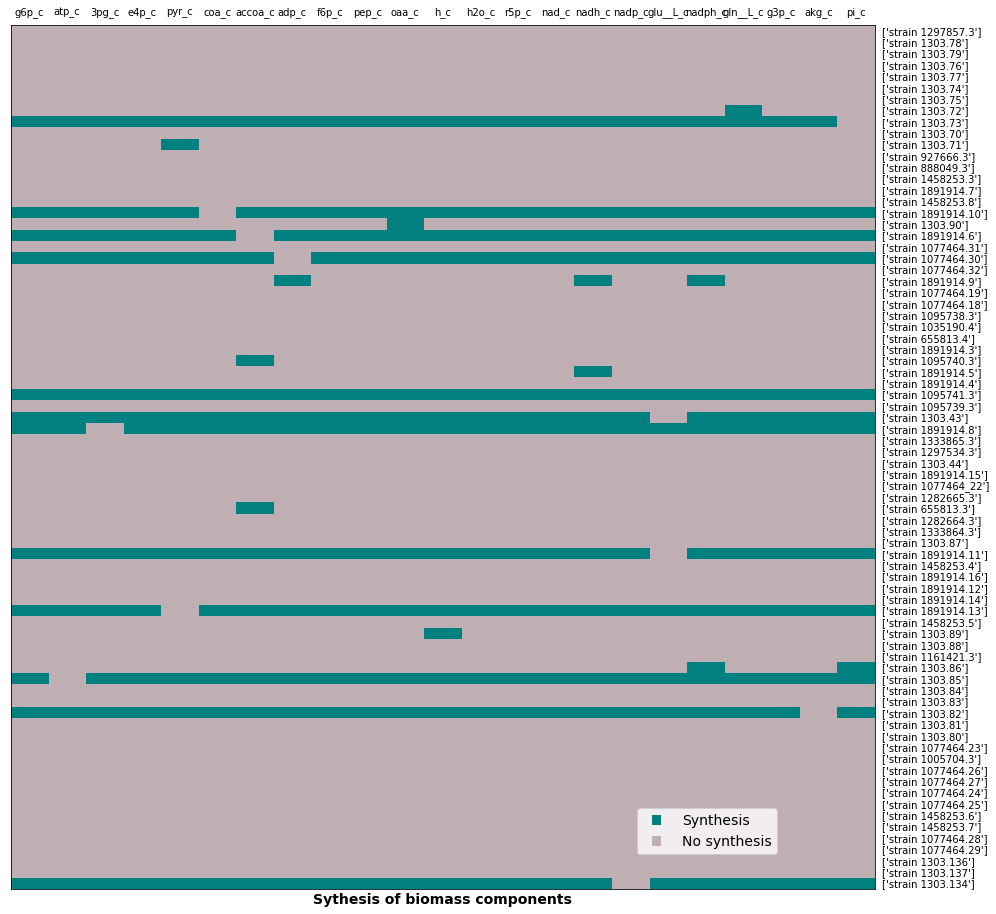

In [14]:
#PLOT PART 3
'''
Code used to generate Figure 2, modeled after Monk et al. PNAS 110(50) 2013
Fig. 2: cluster species by unique growth-supporting conditions

2015 jtyurkovich
'''

from matplotlib.legend_handler import HandlerPatch
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scipy
import scipy.cluster.hierarchy as sch
%matplotlib inline

# to get squares in legend
class HandlerSquare(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = xdescent + 0.5 * (width - height), ydescent
        p = mpatches.Rectangle(xy=center, width=height,
                               height=height, angle=0.0)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

# define strains (y axis labels)
# TODO: replace with new results

data_aux=[]
num_strains = 76 #76
num_metabolites = 23
strains_all=[]

for strain in strains_list:
    strains = ['strain ' + strain]
    strains_all.append(strains)
    data_aux.append(dic_part3[strain])
    
# populate with growth/no growth data
# TODO: replace with new results
# CARBON SOURCE
data = data_aux

#print strains_all
strains=strains_all
# plot heatmap with dendrogram
fig = plt.figure()

n = [x for x in range(num_strains)]
n2 = [x2 for x2 in range(num_metabolites)]
cmap = colors.ListedColormap(['#bfafb2', '#008080'])
#cmap = colors.ListedColormap(['#bfafb2', '#008080'])

#ax1 = fig.add_axes([0.3,0.1,1,1])
ax1 = fig.add_axes([0.0,0.1,2,3])
#ax1.matshow(data, aspect='auto', origin='lower', cmap=colors.ListedColormap(['#008080','#bfafb2' ]))#cmap=cmap)
ax1.matshow(data, aspect='auto', origin='lower', cmap=colors.ListedColormap(['#bfafb2','#008080' ]))#cmap=cmap)
plt.xticks([])
plt.yticks(n, strains, size=10)
ax1.yaxis.tick_right()
plt.xlabel('Sythesis of biomass components', fontweight='bold', size=14)
plt.xticks(n2, metabolites_list, size=10)

plt.tick_params(
    axis='y',
    which='both',
    left='off',
    right='off'
)

plt.tick_params(
    axis='x',
    which='both',
    bottom='off',
    top='off'
)
#ax2 = fig.add_axes([0.0, 0.1, 0.2, 1], frame_on=False)
ax2 = fig.add_axes([0.09, 0.1, 0.2, 1], frame_on=False)
links = sch.linkage(data, method='centroid')
#z = sch.dendrogram(links, color_threshold=0, color_list=['#000000', '#000000'], orientation='right')
ax2.set_xticks([])
ax2.set_yticks([])

tmp1 = plt.Rectangle((0, 0), 1, 1, fc='#008080')
tmp2 = plt.Rectangle((0, 0), 1, 1, fc='#bfafb2')
plt.legend([tmp1, tmp2], ['Synthesis', 'No synthesis'], fontsize=14, handler_map={tmp1: HandlerSquare(), tmp2: HandlerSquare()}, loc='right', bbox_to_anchor=(8.5, 0.2))

plt.show()
fig.savefig('fig-2_EB.png', bbox_inches='tight', dpi=600)
fig.savefig('fig-2_EB.pdf', bbox_inches='tight', dpi=600)

# 4. Growth capability in different nutrient environment

Growth in different carbon sources: 

1. Loop through the exchange reactions in your model. If the exchanged metabolite contains C in its formula, it can be used either as a carbon source.
2. Set the default carbon exchange reactions to 0, and change of the lower bound of the exchange reaction of interest. 
3. Simulate growth, record growth/no growth 

Do this for both Nitrogen/Carbon sources for all strains

In [24]:
growthThreshold

0.000705242053103619

In [10]:
# Function to test growth capability on different nutrients. Inputs include base model, strain-specific model,
# source type growth dictionary to record growth, a list in which tested sources can be recorded, and growth threshold


# basemodel: your curated base model e.g. basemodel=cobra.io.load_json_model('./data/model_base.json')
# model: a strain-specific model e.g. model=cobra.io.load_json_model('./data/model_1.json')
# dic: an empty dictionary  e.g. dic={}
# source: C or N e.g. source='C'
# sourcelist: an empty list that will record the list of nutrient sources tested e.g. sourcelist=[]
# threshold: set the theshold for growth/no growth e.g. threshold = 0.001

def growth_cap(model,source, dic,sourcelist,threshold):

    print 'testing : '+ str(source) +' source for:'
    strainName=model.name
    print strainName
    # set objective function
    for rxn in model.reactions:
        rxn.objective_coefficient =0 
        
    model.reactions.get_by_id('BIOMASS_Ecoli_core_w_GAM').objective_coefficient = 1 # change to your own biomass function

# defalut reactions are different depending on the source type input 
    if source=='C': 
        default_rxn='EX_glc__e' #change based on your model
    elif source=='N':
        default_rxn='EX_nh4__e' #change based on your model
# record the lowered bound for default reaction 
    for rxn in model.reactions:
        if rxn.id == default_rxn:
            default_bound=rxn.lower_bound
            print default_bound
#set default reaction lowerbound to zero
    temp_growth_cap=[]
    model.reactions.get_by_id(default_rxn).lower_bound=0
    
    for ex in model.reactions:
        if ex.id[:2] == 'EX':
            if source in ex.check_mass_balance().keys(): 
                #save the original value -- in case it was non-zero originally
                orginal_lb=model.reactions.get_by_id(ex.id).lower_bound
                #print original_lb
                
                #change the lower bound 
                model.reactions.get_by_id(str(ex.id)).lower_bound = -10.
                current_source=ex.id.split("EX_")[1].split('__e')[0]
                #print current_source
                
                if not current_source in sourcelist: 
                    sourcelist.append(current_source)
                if model.optimize().f < threshold:
                    temp_growth_cap.append(0)
                else:
                    temp_growth_cap.append(1)
                model.reactions.get_by_id(ex.id).lower_bound = orginal_lb
    
    #set default_C_source.lb back to default value
    model.reactions.get_by_id(default_rxn).lower_bound=default_bound
    dic.update({str(strainName):temp_growth_cap})    


In [11]:
#Carbon source
directory = 'C:\Users\isabel\Downloads\strains/'
#directory = '../S_oralis/strains/'
source1 = 'C'
dic={}
sourcelist=[]
threshold = 0.000165184224631
e_coli = cobra.io.load_json_model('C:\Users\isabel\Downloads/e_coli_core.json')
#e_coli = cobra.io.load_json_model('../Resources/data/e_coli_core.json')
new_biomass = e_coli.reactions.BIOMASS_Ecoli_core_w_GAM

for filename in os.listdir(directory):
    strain = cobra.io.load_json_model(directory + filename)
    if strain.name in strains_list: 
        strain.add_reaction(new_biomass)
        growth_cap(strain,source1, dic,sourcelist,threshold)

testing : C source for:
1005704.3
-4.0785
testing : C source for:
1035190.4
-4.0785
testing : C source for:
1077464.18
-4.0785
testing : C source for:
1077464.19
-4.0785
testing : C source for:
1077464.23
-4.0785
testing : C source for:
1077464.24
-4.0785
testing : C source for:
1077464.25
-4.0785
testing : C source for:
1077464.26
-4.0785
testing : C source for:
1077464.27
-4.0785
testing : C source for:
1077464.28
-4.0785
testing : C source for:
1077464.29
-4.0785
testing : C source for:
1077464.30
-4.0785
testing : C source for:
1077464.31
-4.0785
testing : C source for:
1077464.32
-4.0785
testing : C source for:
1077464_22
-4.0785
testing : C source for:
1095738.3
-4.0785
testing : C source for:
1095739.3
-4.0785
testing : C source for:
1095740.3
-4.0785
testing : C source for:
1095741.3
-4.0785
testing : C source for:
1161421.3
-4.0785
testing : C source for:
1282664.3
-4.0785
testing : C source for:
1282665.3
-4.0785
testing : C source for:
1297534.3
-4.0785
testing : C source fo

In [7]:
#Carbon source
#dic

In [8]:
#sourcelist
len(sourcelist)

61

In [16]:
#Nitrogen source
directory = 'C:\Users\isabel\Downloads\strains/'
#directory = '../S_oralis/strains/'
source2 = 'N'
dic2={}
sourcelist2=[]
threshold2 = 0.000165184224631
e_coli = cobra.io.load_json_model('C:\Users\isabel\Downloads/e_coli_core.json')
#e_coli = cobra.io.load_json_model('../Resources/data/e_coli_core.json')
new_biomass = e_coli.reactions.BIOMASS_Ecoli_core_w_GAM

for filename in os.listdir(directory):
    strain = cobra.io.load_json_model(directory + filename)
    if strain.name in strains_list: 
        strain.add_reaction(new_biomass)
        growth_cap(strain,source2, dic2,sourcelist2,threshold2)

testing : N source for:
1005704.3
-1000.0
testing : N source for:
1035190.4
-1000.0
testing : N source for:
1077464.18
-1000.0
testing : N source for:
1077464.19
-1000.0
testing : N source for:
1077464.23
-1000.0
testing : N source for:
1077464.24
-1000.0
testing : N source for:
1077464.25
-1000.0
testing : N source for:
1077464.26
-1000.0
testing : N source for:
1077464.27
-1000.0
testing : N source for:
1077464.28
-1000.0
testing : N source for:
1077464.29
-1000.0
testing : N source for:
1077464.30
-1000.0
testing : N source for:
1077464.31
-1000.0
testing : N source for:
1077464.32
-1000.0
testing : N source for:
1077464_22
-1000.0
testing : N source for:
1095738.3
-1000.0
testing : N source for:
1095739.3
-1000.0
testing : N source for:
1095740.3
-1000.0
testing : N source for:
1095741.3
-1000.0
testing : N source for:
1161421.3
-1000.0
testing : N source for:
1282664.3
-1000.0
testing : N source for:
1282665.3
-1000.0
testing : N source for:
1297534.3
-1000.0
testing : N source fo

In [1]:
dic2

NameError: name 'dic2' is not defined

In [11]:
len(sourcelist2)

45

In [ ]:
#strains_list=[]
#directory = 'C:\Users\isabel\Downloads\strains/'
#directory = '../S_oralis/strains/'

#for filename in os.listdir(directory):
#    strain = cobra.io.load_json_model(directory + filename)
#    strains_list.append(str(strain.name))

In [11]:
print strains_list
len(strains_list)

['1303.134', '1891914.6', '1303.82', '1077464.30', '1095741.3', '1303.73', '1303.85', '1891914.8', '1303.43', '1891914.10', '1891914.11', '1891914.13']


12

In [ ]:
#for strain in strains_list:
#    print dic[strain]

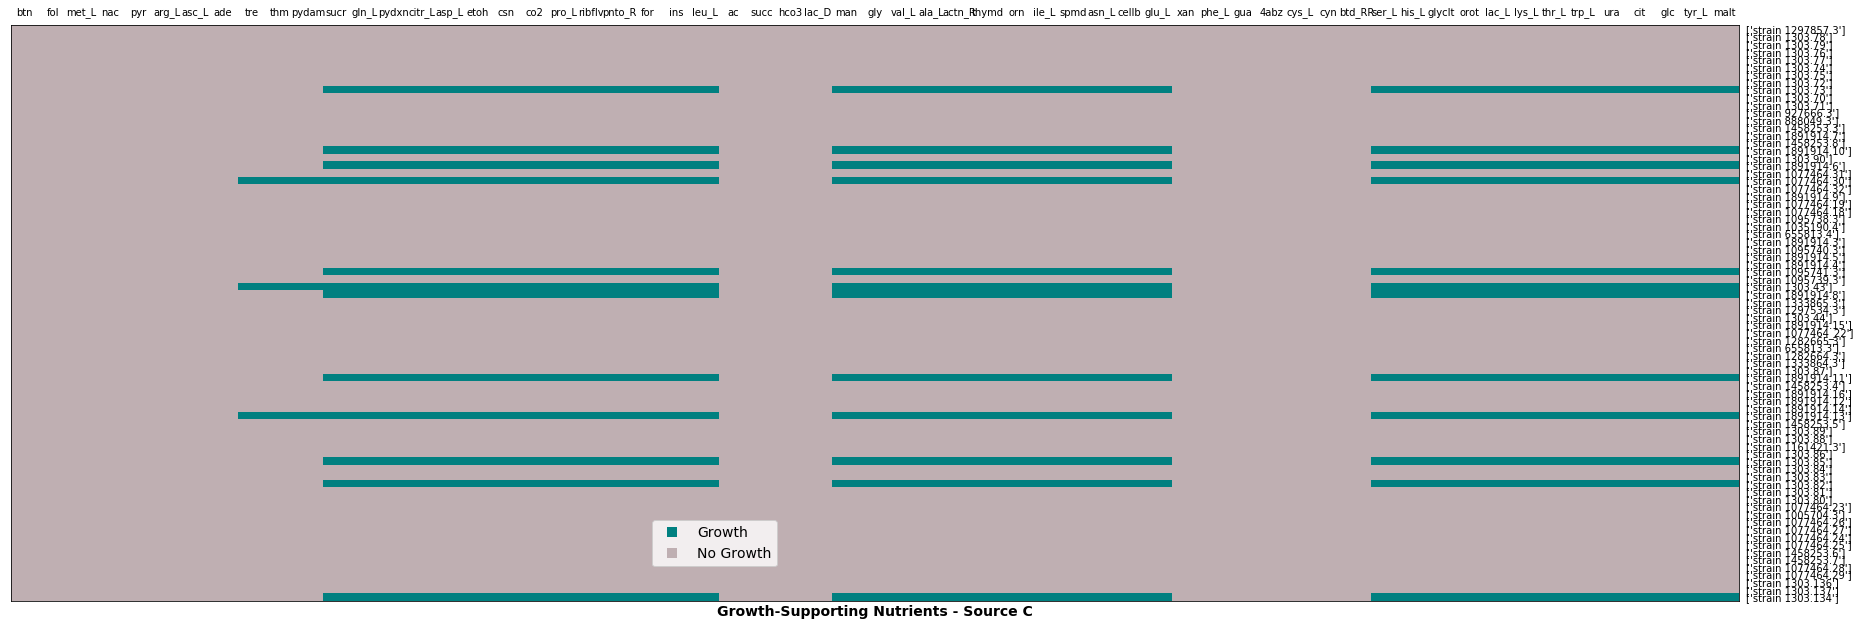

KeyboardInterrupt: 

In [15]:
#PLOT PART 4
'''
Code used to generate Figure 2, modeled after Monk et al. PNAS 110(50) 2013
Fig. 2: cluster species by unique growth-supporting conditions

2015 jtyurkovich
'''

from matplotlib.legend_handler import HandlerPatch
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scipy
import scipy.cluster.hierarchy as sch
%matplotlib inline

# to get squares in legend
class HandlerSquare(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = xdescent + 0.5 * (width - height), ydescent
        p = mpatches.Rectangle(xy=center, width=height,
                               height=height, angle=0.0)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

# define strains (y axis labels)
# TODO: replace with new results

data_aux=[]
num_strains = 76
num_met = len(sourcelist) #61
strains_all=[]

for strain in strains_list:
    strains = ['strain ' + strain]
    strains_all.append(strains)
    data_aux.append(dic[strain])
    
# populate with growth/no growth data
# TODO: replace with new results
# CARBON SOURCE
data = data_aux

#print strains_all
strains=strains_all
# plot heatmap with dendrogram
fig = plt.figure()

n = [x for x in range(num_strains)]
n2 = [met for met in range(num_met)]
cmap = colors.ListedColormap(['#bfafb2', '#008080'])

#ax1 = fig.add_axes([0.3,0.1,1,1])
ax1 = fig.add_axes([0.0,0.1,4,2])
ax1.matshow(data, aspect='auto', origin='lower', cmap=cmap)
plt.xticks([])
plt.yticks(n, strains, size=10)
ax1.yaxis.tick_right()
plt.xlabel('Growth-Supporting Nutrients - Source C', fontweight='bold', size=14)
plt.xticks(n2, sourcelist, size=10)

plt.tick_params(
    axis='y',
    which='both',
    left='off',
    right='off'
)

plt.tick_params(
    axis='x',
    which='both',
    bottom='off',
    top='off'
)

ax2 = fig.add_axes([0.09, 0.1, 0.2, 1], frame_on=False)
links = sch.linkage(data, method='centroid')
#z = sch.dendrogram(links, color_threshold=0, color_list=['#000000', '#000000'], orientation='right')
ax2.set_xticks([])
ax2.set_yticks([])

tmp1 = plt.Rectangle((0, 0), 1, 1, fc='#008080')
tmp2 = plt.Rectangle((0, 0), 1, 1, fc='#bfafb2')
plt.legend([tmp1, tmp2], ['Growth', 'No Growth'], fontsize=14, handler_map={tmp1: HandlerSquare(), tmp2: HandlerSquare()}, loc='right', bbox_to_anchor=(8.5, 0.2))

plt.show()
fig.savefig('fig-2.png', bbox_inches='tight', dpi=600)
fig.savefig('fig-2.pdf', bbox_inches='tight', dpi=600)

In [19]:
for strain in strains_list:
    print dic2[strain]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

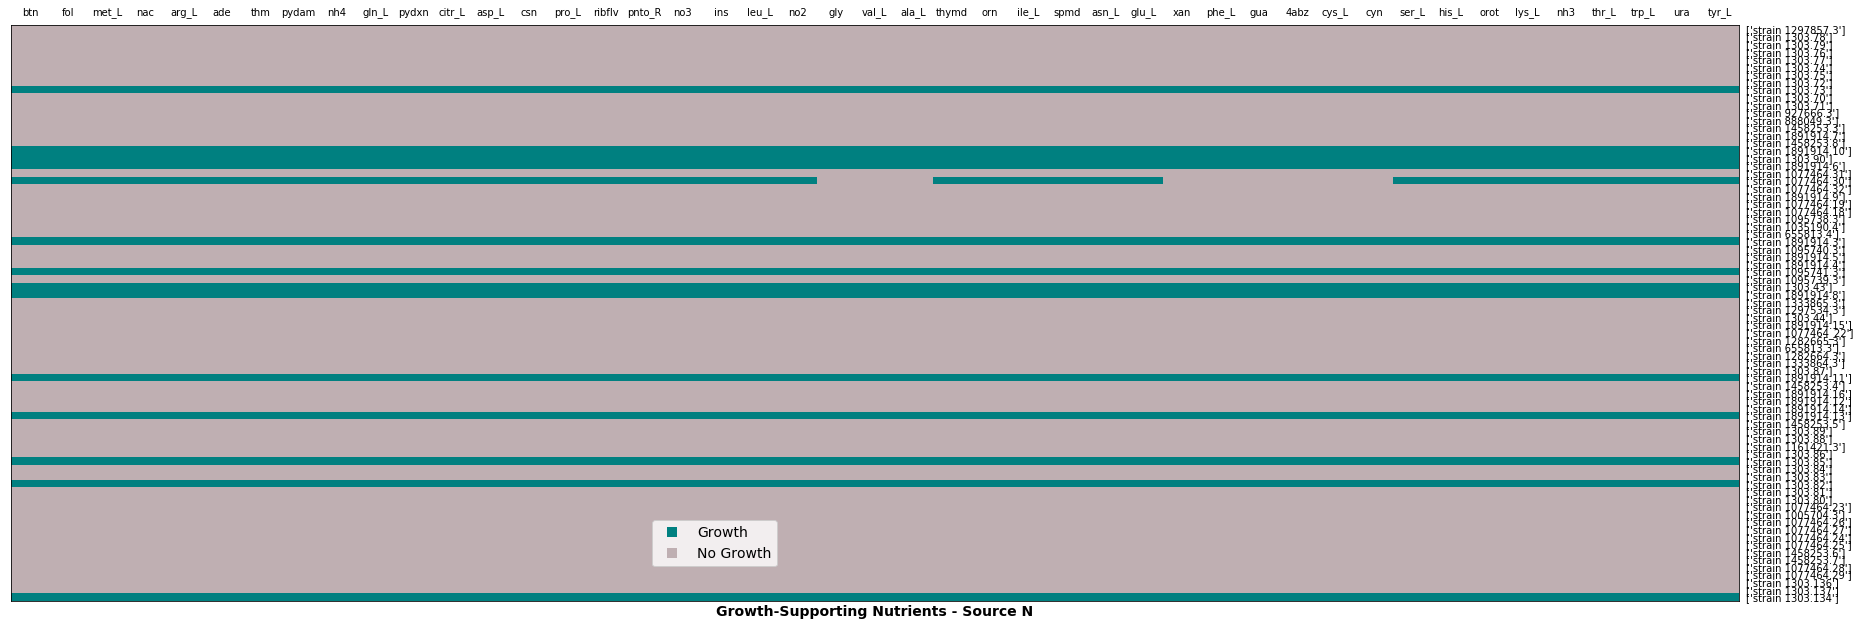

In [20]:
#PLOT PART 4 SOURCE N
'''
Code used to generate Figure 2, modeled after Monk et al. PNAS 110(50) 2013
Fig. 2: cluster species by unique growth-supporting conditions

2015 jtyurkovich
'''

from matplotlib.legend_handler import HandlerPatch
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scipy
import scipy.cluster.hierarchy as sch
%matplotlib inline

# to get squares in legend
class HandlerSquare(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = xdescent + 0.5 * (width - height), ydescent
        p = mpatches.Rectangle(xy=center, width=height,
                               height=height, angle=0.0)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

# define strains (y axis labels)
# TODO: replace with new results

data_aux=[]
num_strains = 76
strains_all=[]
num_met2 = len(sourcelist2) #45

for strain in strains_list:
    strains = ['strain ' + strain]
    strains_all.append(strains)
    data_aux.append(dic2[strain])
    
# populate with growth/no growth data
# TODO: replace with new results
# NITROGEN SOURCE
data = data_aux

#print strains_all
strains=strains_all
# plot heatmap with dendrogram
fig = plt.figure()

n = [x for x in range(num_strains)]
n3 = [met for met in range(num_met2)]
cmap = colors.ListedColormap(['#bfafb2', '#008080'])
#cmap = colors.ListedColormap(['#008080', '#bfafb2'])

#ax1 = fig.add_axes([0.3,0.1,1,1])
ax1 = fig.add_axes([0.0,0.1,4,2])
ax1.matshow(data, aspect='auto', origin='lower', cmap=cmap)
plt.xticks([])
plt.yticks(n, strains, size=10)
ax1.yaxis.tick_right()
plt.xlabel('Growth-Supporting Nutrients - Source N', fontweight='bold', size=14)
plt.xticks(n3, sourcelist2, size=10)

plt.tick_params(
    axis='y',
    which='both',
    left='off',
    right='off'
)

plt.tick_params(
    axis='x',
    which='both',
    bottom='off',
    top='off'
)

ax2 = fig.add_axes([0.09, 0.1, 0.2, 1], frame_on=False)
links = sch.linkage(data, method='centroid')
#z = sch.dendrogram(links, color_threshold=0, color_list=['#000000', '#000000'], orientation='right')
ax2.set_xticks([])
ax2.set_yticks([])

tmp1 = plt.Rectangle((0, 0), 1, 1, fc='#008080')
tmp2 = plt.Rectangle((0, 0), 1, 1, fc='#bfafb2')
plt.legend([tmp1, tmp2], ['Growth', 'No Growth'], fontsize=14, handler_map={tmp1: HandlerSquare(), tmp2: HandlerSquare()}, loc='right', bbox_to_anchor=(8.5, 0.2))

plt.show()
fig.savefig('fig-2.png', bbox_inches='tight', dpi=600)
fig.savefig('fig-2.pdf', bbox_inches='tight', dpi=600)